## Embedded, interpolated datasets

Non-cartesian coordinate systems are common in the physical sciences, but many visualization and analysis tools are optimized for cartesian coordinates. 3D volume rendering, for example, typically requires transformation from a dataset's native non-cartesian coordinate systems to cartesian. 

yt_xarray provides a framework for building an interpolation pipeline that results in a cartesian yt dataset in which the required transformations and interpolations are embedded within the functions that yt uses to fetch data. As a result, interpolation happens on demand as yt needs data, circumventing the need for pre-interpolating data onto a cartesian grid. 

An embedded interpolation pipeline is built in 3 steps:

1. load your xarray dataset
2. initialize an appropriate `yt_xarray.transformations.Transformer` (or write your own) that provides methods to go from your dataset's native coordinates to 3D cartesian coordinates
3. initialize a yt cartesian dataset using `yt_xarray.transformations.build_interpolated_cartesian_ds`

### Using the `GeocentricCartesian` transformer

One of the available transformation objects, `GeocentricCartesian`, implements transformations from 3D geographic coordinates (radius/altitude/depth, latitude, longitude) to cartesian coordinates. To use it, provide the `radial_type`: one of `"radius"`, `"altitude"` or , `"depth"`. For the latter two, the transformation will include an offset by subtracting or adding the reference radius, which can be controlled by the `r_o` parameter:

In [1]:
from yt_xarray.transformations import GeocentricCartesian

gc = GeocentricCartesian('radius', r_o = 5000) 

The `gc` object has a number of important properties and methods. `native_coords` and `transformed_coords` are ordered tuples of the coordinate names in the native (geographic) and transformed (cartesian) systems

In [2]:
gc.native_coords

('radius', 'latitude', 'longitude')

In [3]:
gc.transformed_coords

('x', 'y', 'z')

Transformations are calculated using the `to_transformed` and `to_native` methods. These methods accept keyword arguments that match the names from the `native_coords` and `transformed_coords` tuples. The coordinate values can be single floats,

In [4]:
gc.to_transformed(radius=5000, latitude=30, longitude=120)

(-2165.0635094610957, 3750.0000000000005, 2500.0000000000005)

or arrays of the same size

In [5]:
import numpy as np 
x, y, z = gc.to_transformed(radius=np.linspace(0.1,5000,10), 
                  latitude=np.full((10,), 30), 
                  longitude=np.linspace(0, 360., 10))
x, y, z

(array([ 8.66025404e-02,  3.68622275e+02,  1.67104733e+02, -7.21716704e+02,
        -1.80848450e+03, -2.26058528e+03, -1.44339011e+03,  5.84828971e+02,
         2.94851381e+03,  4.33012702e+03]),
 array([ 0.00000000e+00,  3.09310815e+02,  9.47698036e+02,  1.25005000e+03,
         6.58234528e+02, -8.22785755e+02, -2.50002500e+03, -3.31672991e+03,
        -2.47409685e+03, -1.06057524e-12]),
 array([5.00000000e-02, 2.77822222e+02, 5.55594444e+02, 8.33366667e+02,
        1.11113889e+03, 1.38891111e+03, 1.66668333e+03, 1.94445556e+03,
        2.22222778e+03, 2.50000000e+03]))

`to_transformed` will return values in the same coordinate order as the `transformed_coords` tuple.

To reverse the transformation, use `to_native`:

In [6]:
gc.to_native(x=x, y=y, z=z)

(array([1.00000000e-01, 5.55644444e+02, 1.11118889e+03, 1.66673333e+03,
        2.22227778e+03, 2.77782222e+03, 3.33336667e+03, 3.88891111e+03,
        4.44445556e+03, 5.00000000e+03]),
 array([30., 30., 30., 30., 30., 30., 30., 30., 30., 30.]),
 array([  0.,  40.,  80., 120., 160., 200., 240., 280., 320., 360.]))

### embedding a transformer within a cartesian yt dataset 

The function, `yt_xarray.transformations.build_interpolated_cartesian_ds` accepts an xarray dataset and a transformer (and some additional optional arguments) and returns a cartesian yt dataset. 

Let's first load in some random data with coordinates of ("altitude", "latitude", "longitude"), initialize a new `GeocentricCartesian` transformer and then build the interpolated dataset for a single field (while you can include more fields in the interpolated dataset, those fields must all have the same dimensions):

In [7]:
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds
from yt_xarray.sample_data import load_random_xr_data
import numpy as np 

fields = {
        "field0": ("altitude", "latitude", "longitude"),
    }
dims = {
    "altitude": (100, 5000, 32),
    "latitude": (10, 50, 32),
    "longitude": (10, 50, 22),
}
ds = load_random_xr_data(fields, dims)

gc = GeocentricCartesian(radial_type='altitude', r_o=6371.)
ds_yt = build_interpolated_cartesian_ds(ds, gc, fields='field0')

yt : [INFO     ] 2024-04-25 14:39:38,732 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-25 14:39:38,732 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-25 14:39:38,733 Parameters: domain_left_edge          = [2673.  722. 1123.]
yt : [INFO     ] 2024-04-25 14:39:38,733 Parameters: domain_right_edge         = [11029.  8579.  8711.]
yt : [INFO     ] 2024-04-25 14:39:38,733 Parameters: cosmological_simulation   = 0


At this stage, no transformations or interpolations have actually occured. The yt dataset, `ds_yt`, however is a uniformly gridded cartesian dataset (a subsequent notebook will describe how to add additional grid refinement)

In [8]:
ds_yt.coordinates.name

'cartesian'

In [9]:
ds_yt.index.grids

array([StreamGrid_0000 ([64 64 64])], dtype=object)

Once field data is accessed, the interpolation occurs for each yt grid as-needed. For example, reading in all the data to find the extrema

In [10]:
ad = ds_yt.all_data()
mn = np.nanmin(ad["stream", "field0"])
mx = np.nanmax(ad["stream", "field0"])
mn, mx

(unyt_quantity(2.80594227e-05, '(dimensionless)'),
 unyt_quantity(0.99993815, '(dimensionless)'))

or plotting

yt : [INFO     ] 2024-04-25 14:39:39,130 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:39,137 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:39,142 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:39,142 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:39,147 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



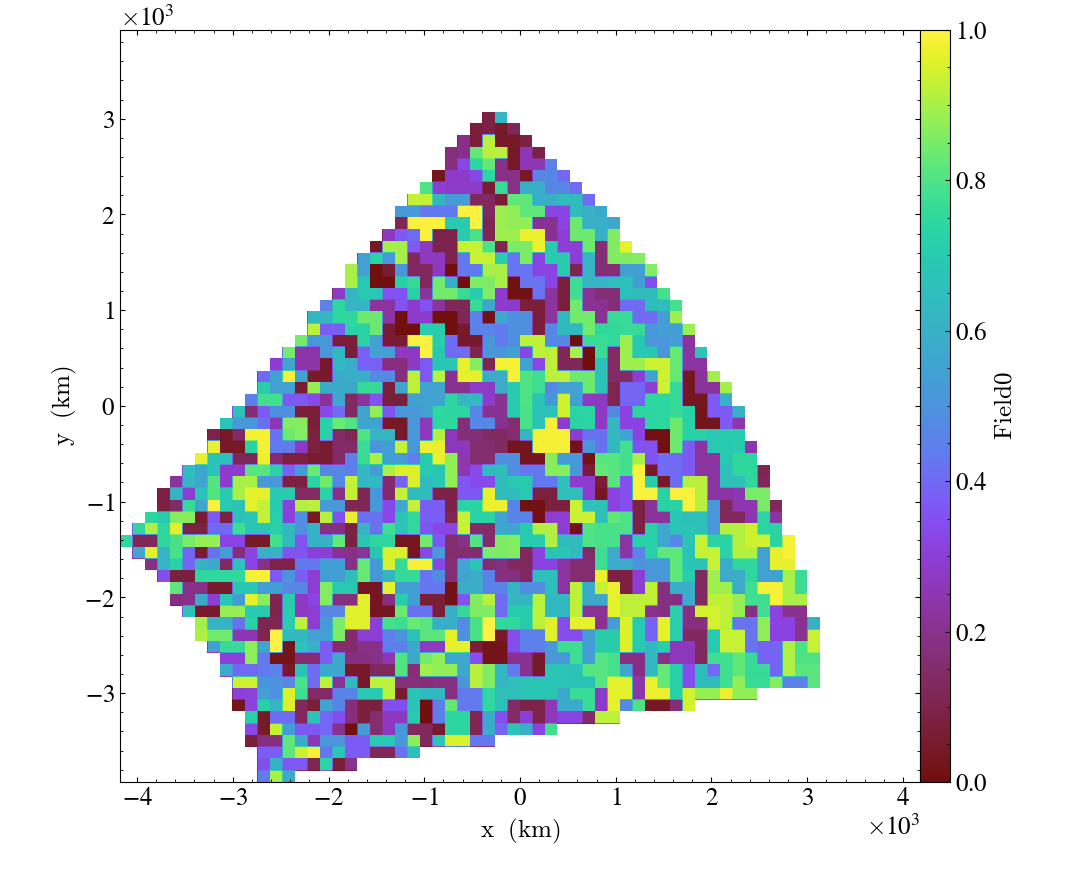

In [11]:
import yt 

slc = yt.SlicePlot(ds_yt, 'z', ('stream', 'field0'))
slc.set_log(('stream', 'field0'), False)
slc.set_zlim(('stream', 'field0'), 0, 1)
slc

`build_interpolated_cartesian_ds` accepts a number of keyword options to control the interpolation. 

* `fill_value` : points falling outside the bounds of the native coordinate extents are assigned this value.
* `grid_resolution`: a list of ints that specify the resolution of the coarsest grid. In the examples here, this is the resulting resolution of the single uniform grid. See the following notebook for information on grid refinement.
*  `sel_dict` and `sel_dict_type`: you can provide selection dictionary as you would to an xarray `ds.sel` or `ds.isel` to subselect ranges of data to include.
*  `bbox_dict`: similar to `sel_dict`, you can instead provide a bounding box dictionary where keys are the coordinate names and values are 2-element arrays or lists of the desired min and max bounds in native coordiantes. If note provided, the full available domain will be used.
*  `interp_method`: this option controls how the interopolation occurs, can be either `nearest` or `interpolate`. In both cases, yt will calculate the native coordiantes of each x,y,z grid point (using the supplied transformer). Then, if `interp_method` is `nearest`, it will find the closest value in the underlying xarray dataset to fill in the grid points. If equal to `interpolate`, yt will use a linear interpolation (using xarray's own wrapping of scipy's interp functionality).
*  `interp_func`: you can **additionally** provide your own function to handle the interpolation step, see below for an example.

The remainder of the options relate to the optional grid refinement settings, which are described in a following notebook.

An interpolated dataset will result in smoother variations:

yt : [INFO     ] 2024-04-25 14:39:39,708 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-25 14:39:39,708 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-04-25 14:39:39,709 Parameters: domain_left_edge          = [2673.  722. 1123.]
yt : [INFO     ] 2024-04-25 14:39:39,709 Parameters: domain_right_edge         = [11029.  8579.  8711.]
yt : [INFO     ] 2024-04-25 14:39:39,709 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-25 14:39:39,830 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:39,831 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:39,832 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:39,832 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:39,833 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



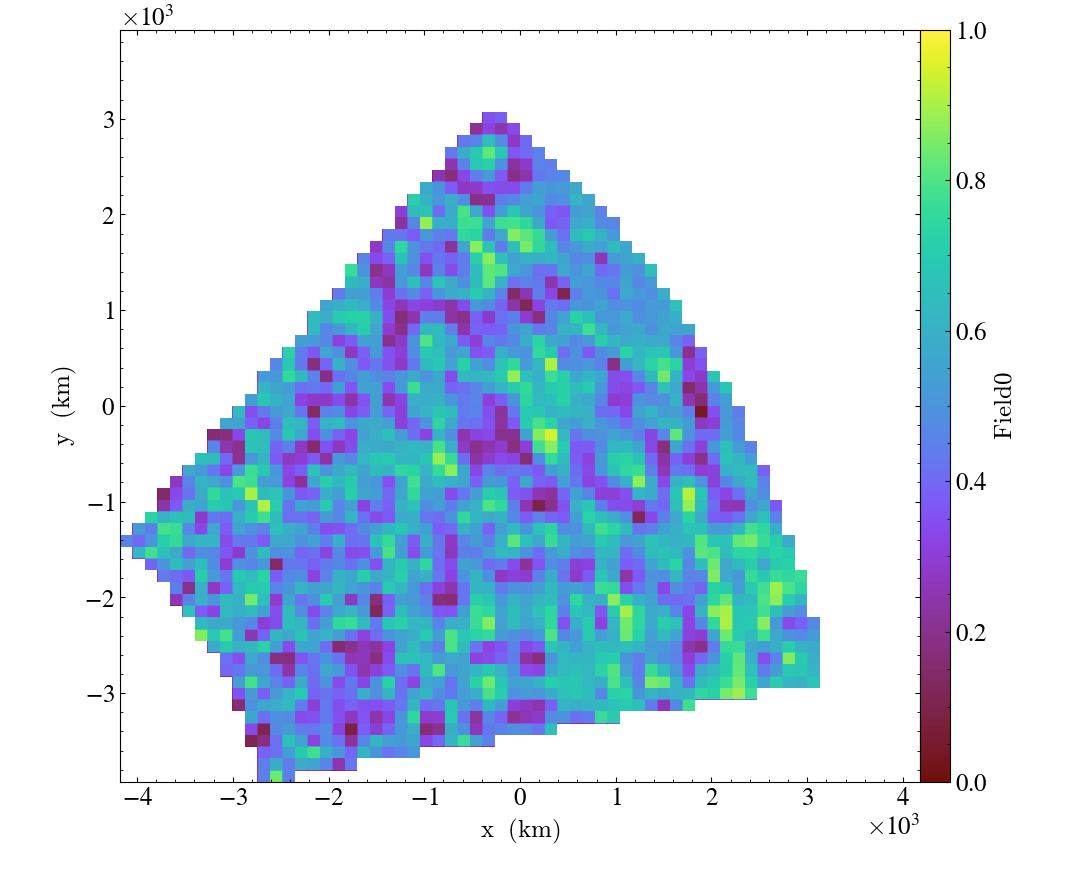

In [12]:
ds_yt = build_interpolated_cartesian_ds(ds, gc, fields='field0', interp_method='interpolate')
slc = yt.SlicePlot(ds_yt, 'z', ('stream', 'field0'))
slc.set_log(('stream', 'field0'), False)
slc.set_zlim(('stream', 'field0'), 0, 1)
slc

while a higher grid resolution will increase the number of probe points, increasing how well the underlying data can be resolved.

yt : [INFO     ] 2024-04-25 14:39:40,202 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-25 14:39:40,202 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-04-25 14:39:40,203 Parameters: domain_left_edge          = [2673.  722. 1123.]
yt : [INFO     ] 2024-04-25 14:39:40,203 Parameters: domain_right_edge         = [11029.  8579.  8711.]
yt : [INFO     ] 2024-04-25 14:39:40,203 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-25 14:39:40,408 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:40,408 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:40,409 xlim = 2673.000000 11029.000000
yt : [INFO     ] 2024-04-25 14:39:40,410 ylim = 722.000000 8579.000000
yt : [INFO     ] 2024-04-25 14:39:40,410 Making a fixed resolution buffer of (('stream', 'field0')) 800 by 800



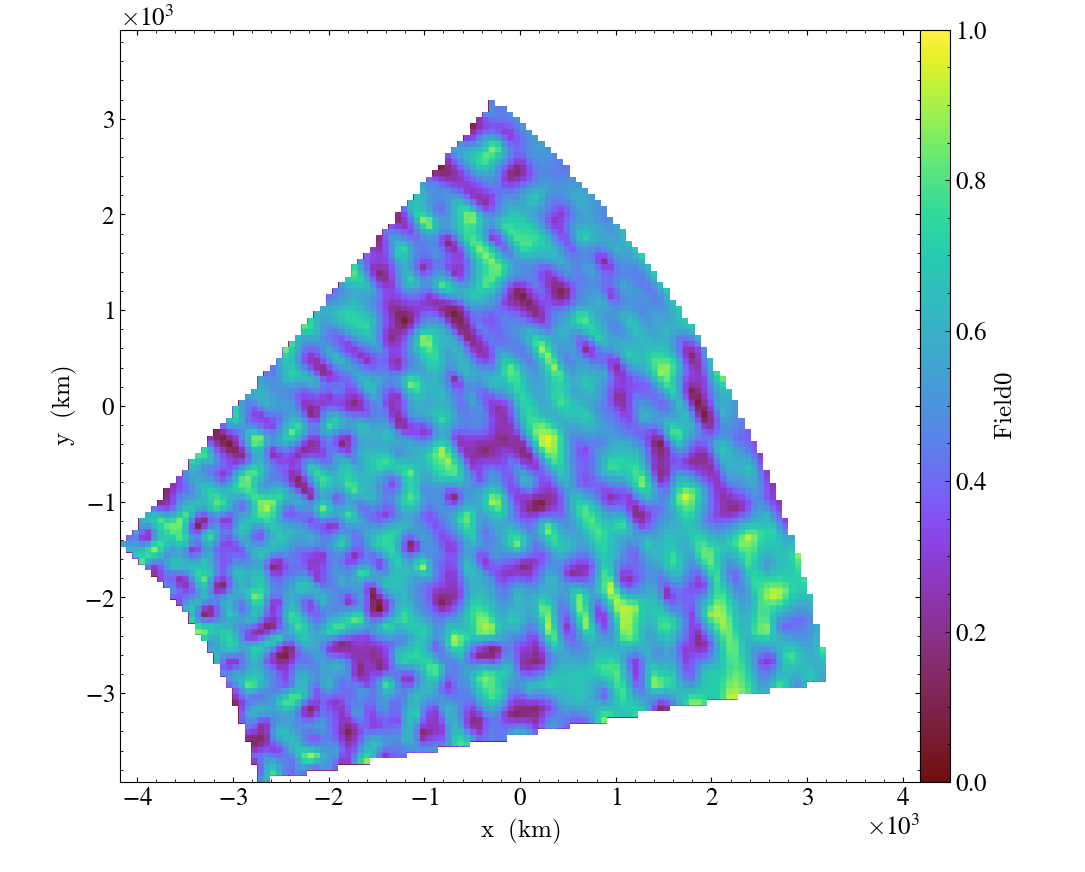

In [13]:
ds_yt = build_interpolated_cartesian_ds(ds, gc, 
                                        fields='field0',              
                                        interp_method='interpolate',
                                       grid_resolution=(128, 128, 128))
slc = yt.SlicePlot(ds_yt, 'z', ('stream', 'field0'))
slc.set_log(('stream', 'field0'), False)
slc.set_zlim(('stream', 'field0'), 0, 1)
slc

### Embedded transformations for volume rendering 

One of the advantages of this process is how it simplifies the process of volume rendering. 

As an example, we'll use an example from the SAGE/IRIS earth model database. In this case, we'll use the regional upper mantle tomography model from Schmandt and Humphreys (2010, [doi:10.1016/j.epsl.2010.06.047](https://doi.org/10.1016/j.epsl.2010.06.047), accessible at [doi:10.17611/DP/9991760](https://doi.org/10.17611/DP/9991760)). 

First, for reference, let's load up the dataset in yt in its native cooridinates (depth, latitude, longitude) and plot a slice: 

yt_xarray : [INFO ] 2024-04-25 14:39:40,867:  Inferred geometry type is geodetic. To override, use ds.yt.set_geometry
yt_xarray : [INFO ] 2024-04-25 14:39:40,868:  Attempting to detect if yt_xarray will require field interpolation:
yt_xarray : [INFO ] 2024-04-25 14:39:40,868:      stretched grid detected: yt_xarray will interpolate.
yt : [INFO     ] 2024-04-25 14:39:40,892 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-25 14:39:40,893 Parameters: domain_dimensions         = [ 18  92 121]
yt : [INFO     ] 2024-04-25 14:39:40,893 Parameters: domain_left_edge          = [  60.     27.5  -125.75]
yt : [INFO     ] 2024-04-25 14:39:40,893 Parameters: domain_right_edge         = [885.   50.5 -95.5]
yt : [INFO     ] 2024-04-25 14:39:40,894 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-25 14:39:40,927 xlim = -125.750000 -95.500000
yt : [INFO     ] 2024-04-25 14:39:40,927 ylim = 27.500000 50.500000
yt : [INFO     ] 2024-04-25 14:39:40,927 Setting origin


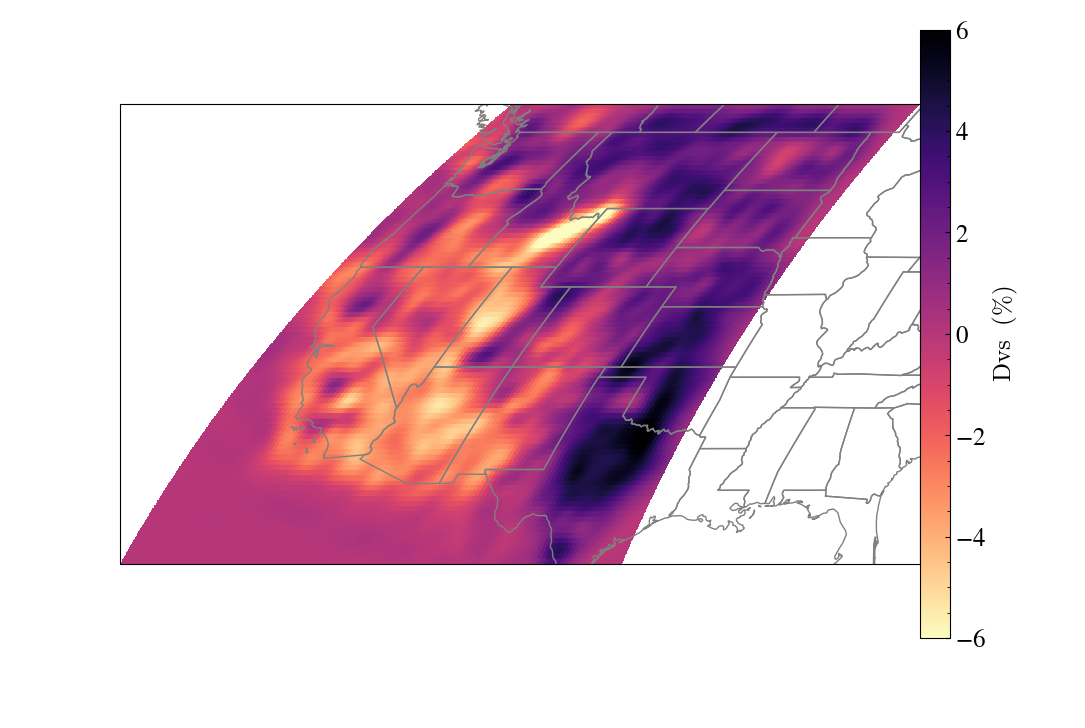

In [14]:
import yt_xarray
import yt
from cartopy.feature import NaturalEarthFeature

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")
yt_ds = ds.yt.load_grid(use_callable=True)

c = yt_ds.domain_center.copy()
c[0] = 150.
slc = yt.SlicePlot(yt_ds, "depth", ("stream", "dvs"), center = c)
slc.set_log(("stream", "dvs"), False)
slc.set_cmap(("stream", "dvs"), "magma_r")
slc.set_zlim(("stream", "dvs"), -6, 6)
slc._setup_plots()

states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces')
slc[("stream", "dvs")].axes.add_feature(states, edgecolor='gray')
slc.show()

Now, we'll load up an interpolated yt dataset. And create slice plots along each dimension:

yt : [INFO     ] 2024-04-25 14:39:43,460 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-04-25 14:39:43,460 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-04-25 14:39:43,460 Parameters: domain_left_edge          = [-3271. -5573.  2533.]
yt : [INFO     ] 2024-04-25 14:39:43,461 Parameters: domain_right_edge         = [ -334. -2832.  4870.]
yt : [INFO     ] 2024-04-25 14:39:43,461 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-04-25 14:39:43,860 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:43,861 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:43,862 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:43,862 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:43,863 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



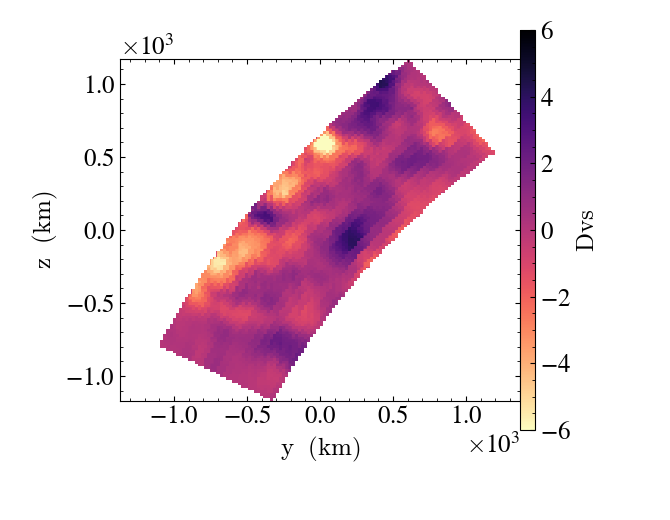

yt : [INFO     ] 2024-04-25 14:39:44,450 xlim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:44,451 ylim = -3271.000000 -334.000000
yt : [INFO     ] 2024-04-25 14:39:44,452 xlim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:44,452 ylim = -3271.000000 -334.000000
yt : [INFO     ] 2024-04-25 14:39:44,453 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



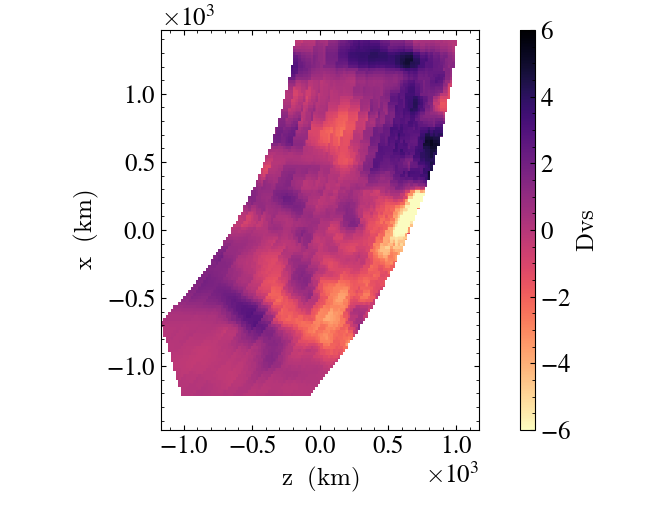

yt : [INFO     ] 2024-04-25 14:39:45,105 xlim = -3271.000000 -334.000000
yt : [INFO     ] 2024-04-25 14:39:45,106 ylim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:45,107 xlim = -3271.000000 -334.000000
yt : [INFO     ] 2024-04-25 14:39:45,107 ylim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:45,108 Making a fixed resolution buffer of (('stream', 'dvs')) 800 by 800



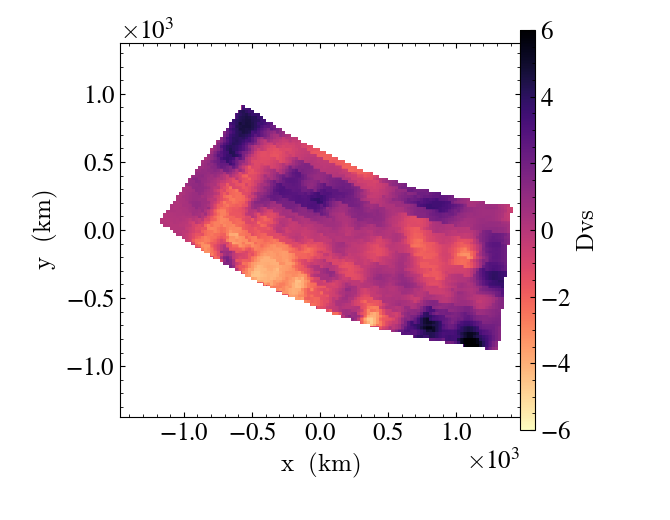

In [15]:
import xarray as xr
import yt_xarray
import yt
from yt_xarray.transformations import GeocentricCartesian, build_interpolated_cartesian_ds

ds = yt_xarray.open_dataset("IRIS/wUS-SH-2010_percent.nc")

grid_resolution = (128, 128, 128)
gc = GeocentricCartesian(radial_type='depth', r_o=6371., use_neg_lons=True)
ds_yt = build_interpolated_cartesian_ds(ds, gc, 
                                        fields='dvs', 
                                        length_unit='km',
                                        grid_resolution=grid_resolution)


for ax in ('x', 'y', 'z'):
    slc = yt.SlicePlot(ds_yt, ax, ('stream', 'dvs'), window_size=(4,4))
    slc.set_log(("stream", "dvs"), False)
    slc.set_cmap(("stream", "dvs"), "magma_r")
    slc.set_zlim(("stream", "dvs"), -6, 6)
    slc.show()

Now, we'll add a new derived field that returns only the negative seismic anomalies, corresponding to seismically slow regions. Additionally, we'll fill in nan values with 0.0 (ray tracing in yt has some trouble with nan values). 

yt : [WARNING  ] 2024-04-25 14:39:45,815 Field ('stream', 'slow_dvs') was added without specifying units or dimensions, auto setting units to 'dimensionless'
yt : [INFO     ] 2024-04-25 14:39:45,816 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:45,816 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:45,817 xlim = -5573.000000 -2832.000000
yt : [INFO     ] 2024-04-25 14:39:45,817 ylim = 2533.000000 4870.000000
yt : [INFO     ] 2024-04-25 14:39:45,818 Making a fixed resolution buffer of (('stream', 'slow_dvs')) 800 by 800



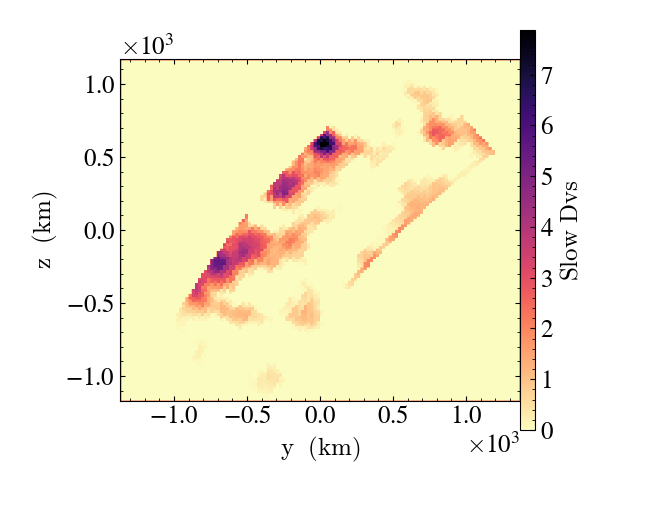

In [16]:

def _slow_vels(field, data):
    # return negative velocities only, 0 all other elements
    dvs = data['stream', 'dvs'].copy()
    dvs[np.isnan(dvs)] = 0.0
    dvs[dvs>0] = 0.0
    return np.abs(dvs)

ds_yt.add_field(
    name=("stream", "slow_dvs"),
    function=_slow_vels,
    sampling_type="local",
)

slc = yt.SlicePlot(ds_yt, 'x', ('stream', 'slow_dvs'), window_size=(4,4))
slc.set_log(("stream", "slow_dvs"), False)
slc.set_cmap(("stream", "slow_dvs"), "magma_r")
slc.annotate_grids(edgecolors=(1,0,0,1))
slc.show()

we're now ready to volume render! In the following, we let `yt` handle the default scene and transfer function creation (by setting the bounds and log convention). The camera settings were manually adjusted to provide a nice "up" orientation: 

yt : [INFO     ] 2024-04-25 14:39:46,075 Rendering scene (Can take a while).
yt : [INFO     ] 2024-04-25 14:39:46,076 Creating volume
yt : [INFO     ] 2024-04-25 14:39:46,425 Creating transfer function


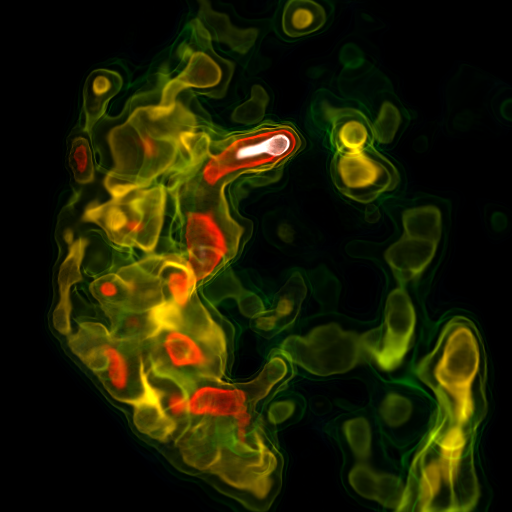

In [17]:
reg = ds_yt.region( ds_yt.domain_center, ds_yt.domain_left_edge, ds_yt.domain_right_edge)
reg

sc = yt.create_scene(reg, field=('stream', 'slow_dvs'))

cam = sc.add_camera(ds_yt)

source = sc[0]

# Set the bounds of the transfer function
source.tfh.set_bounds((0.1, 8))

# set that the transfer function should be evaluated in log space
source.tfh.set_log(True)

# source.tfh.plot("transfer_function.png", profile_field=('stream', 'slow_dvs'))
cam.zoom(2)
cam.yaw(100*np.pi/180)
cam.roll(220*np.pi/180)
cam.rotate(30*np.pi/180)

sc.show(sigma_clip=5.)
